In [5]:
import numpy as np
import scipy
import matplotlib
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
#it might need you to install tensorflow manually. I was able to do that by typing "python3 -m pip install 'tensorflow'" into the terminal.
import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import sklearn
import keras_tuner as kerastuner
#for sklearn, use "pip install -U scikit-learn"

    category                                              image  \
0  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4  cardboard  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                         path  
0    dataset-resized/cardboard/cardboard1.jpg  
1   dataset-resized/cardboard/cardboard10.jpg  
2  dataset-resized/cardboard/cardboard100.jpg  
3  dataset-resized/cardboard/cardboard101.jpg  
4  dataset-resized/cardboard/cardboard102.jpg  
dataset-resized/paper/paper17.jpg


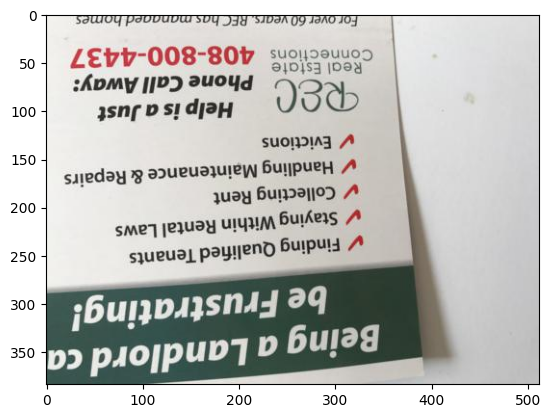

In [6]:
directory = os.fsencode('dataset-resized/cardboard')

#dataframe with each image's category, image file, and filename. May or may not actually get used
image_frame = pd.DataFrame(columns=('category', 'image', 'path'))

#a big array of filenames
filename_array = []
#a big array of images (our "X")
image_array = []
#a big array of categories (our "y")
category_array = []

i = 0

#we basically just run the for loop below six times, once for each category, filling out the arrays and dataframe.
categories = [
    'cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'
]

for category in categories:
    for filename in os.listdir('dataset-resized/' + category):
        current_path = 'dataset-resized/' + category + '/' + filename
        current_image = Image.open(current_path)
        image_frame.loc[i] = {"category" : category, "image" : current_image, "path" : current_path}
        category_array.append(category)
        image_array.append(current_image)
        filename_array.append(current_path)
        i += 1

#test display
print(image_frame.head(5))
print(filename_array[1392])
plt.imshow(image_array[1392])
plt.show()

In [7]:
#Next we'll use the dataframe indexes to make a train-test split.
indices = np.arange(0, 2527)
train_indices, test_indices = sklearn.model_selection.train_test_split(indices, test_size=0.2)

train_frame = image_frame.loc[train_indices]
print(train_frame.head(5))

test_frame = image_frame.loc[test_indices]
print(test_frame.head(5))

     category                                              image  \
2361  plastic  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2262  plastic  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1831    paper  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2434    trash  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2348  plastic  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                        path  
2361   dataset-resized/plastic/plastic73.jpg  
2262  dataset-resized/plastic/plastic418.jpg  
1831      dataset-resized/paper/paper565.jpg  
2434       dataset-resized/trash/trash15.jpg  
2348   dataset-resized/plastic/plastic61.jpg  
     category                                              image  \
2012  plastic  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1358    paper  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2014  plastic  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2215  plastic  <PIL.JpegImagePlugin.J

In [8]:

train_datagen1 = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

#This train datagen thingy should normalize our images. I feed it in the paths from the dataframe.
train_set1 = train_datagen1.flow_from_dataframe(train_frame, x_col="path", y_col="category", target_size=(64,64),
                                                    class_mode="categorical",batch_size=32)

test_set1 = train_datagen1.flow_from_dataframe(test_frame, x_col="path", y_col="category", target_size=(64,64),
                                                    class_mode="categorical",batch_size=32)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [9]:
cnn1 = tf.keras.models.Sequential([ # Old initial cell block without hyperparameter tuning
    tf.keras.layers.Input(shape=(64, 64, 3)),

    tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
    tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2,strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=6, activation='softmax')
])
#if we're trying to push the model to care more about false positives than false negatives,
#maybe this is where we do that? we'll have to look into it further.
cnn1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
cnn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,625,926 (6.20 MB)

 Trainable params: 1,625,926 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
#the tutorial i'm using might be using different definitions for train/validation/test splits
#than we do? if so, probably wouldn't be too hard to fix it at least.
history_initial = cnn1.fit(
    train_set1,
    validation_data=test_set1,
    epochs=10,
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.3365 - loss: 1.6021 - val_accuracy: 0.4407 - val_loss: 1.4680
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.4057 - loss: 1.4543 - val_accuracy: 0.4368 - val_loss: 1.3443
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4330 - loss: 1.3976 - val_accuracy: 0.4585 - val_loss: 1.3042
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.4681 - loss: 1.3454 - val_accuracy: 0.4901 - val_loss: 1.2678
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.5087 - loss: 1.2678 - val_accuracy: 0.5138 - val_loss: 1.2083
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5007 - loss: 1.2590 - val_accuracy: 0.4960 - val_loss: 1.2462
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5567 - loss: 1.1986 - val_accuracy: 0.5455 - val_loss: 1.1600
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5562 - loss: 1.1642 - val_accuracy: 0.5336 - v

In [11]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) 
# To really run the hyperparameter tuner to its best efficiency we need to run it on a GPU, Google Colab is a good resource for this

Num GPUs Available:  0


In [12]:
def build_model(hp):
    model = tf.keras.models.Sequential() #Creates a model with no layers
    model.add(tf.keras.layers.Input(shape=(64, 64, 3)))

    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), #We add onto the layers, but we specify a range of values
        kernel_size=3,                                                         #with a step size, so our hyperparameter tuning knows what to test for.
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=64, max_value=128, step=32),
        kernel_size=3,
        activation='relu'
    ))
    model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))

    model.add(tf.keras.layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.2, max_value=0.6, step=0.1)
    ))

    model.add(tf.keras.layers.Dense(units=6, activation='softmax'))

    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [13]:
tuner = kerastuner.Hyperband( #https://keras.io/keras_tuner/api/tuners/hyperband/
    build_model,
    objective='val_accuracy',
    max_epochs=15,          
    factor=3,
    directory='modelstesting',      
    project_name='trash_tuning'
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(train_set1, 
             validation_data=test_set1, 
             epochs=15, 
             callbacks=[stop_early])

Reloading Tuner from modelstesting\trash_tuning\tuner0.json


In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"conv_1_filter: {best_hps.get('conv_1_filter')}")
print(f"conv_2_filter: {best_hps.get('conv_2_filter')}")
print(f"dense_units: {best_hps.get('dense_units')}")
print(f"dropout_rate: {best_hps.get('dropout_rate')}")
print(f"learning_rate: {best_hps.get('learning_rate')}")

conv_1_filter: 32
conv_2_filter: 96
dense_units: 128
dropout_rate: 0.4
learning_rate: 0.001


In [15]:
#Build the model with the best hyperparameters and train it over 20 epochs now
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_set1, validation_data=test_set1, epochs=20)

Epoch 1/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.3528 - loss: 1.5461 - val_accuracy: 0.4190 - val_loss: 1.4026
Epoch 2/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.4250 - loss: 1.4041 - val_accuracy: 0.4763 - val_loss: 1.3292
Epoch 3/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4894 - loss: 1.2901 - val_accuracy: 0.4921 - val_loss: 1.1929
Epoch 4/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5502 - loss: 1.1771 - val_accuracy: 0.5395 - val_loss: 1.1531
Epoch 5/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.5458 - loss: 1.1938 - val_accuracy: 0.5395 - val_loss: 1.1608
Epoch 6/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.5868 - loss: 1.0975 - val_accuracy: 0.5494 - val_loss: 1.1001
Epoch 7/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6002 - loss: 1.0697 - val_accuracy: 0.5791 - val_loss: 1.1055
Epoch 8/20
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6215 - loss: 1.0169 - val_accuracy: 0.5889 - v

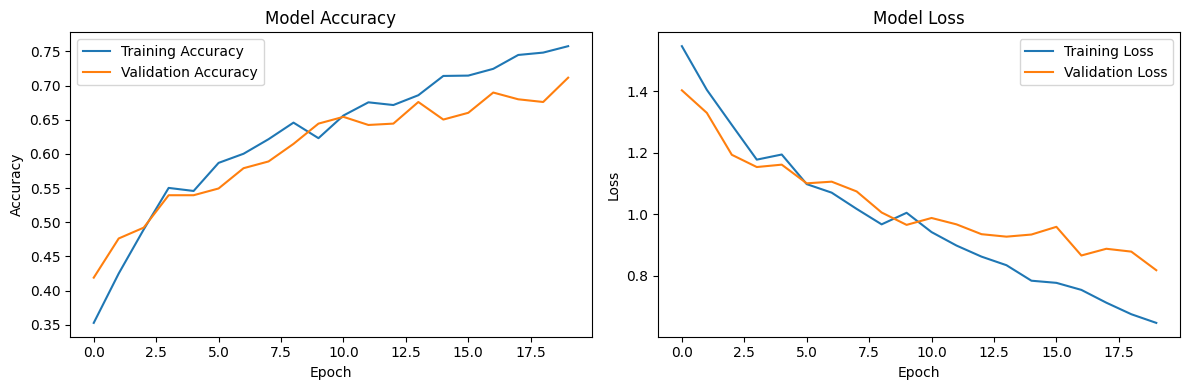

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.6996 - loss: 0.8530

Test Accuracy: 0.6996
Test Loss: 0.8530


In [17]:
h = history # history_initial
#compare between initial parameters (histroy_initial) and hyperparameter tuned model (history)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(h.history['accuracy'], label='Training Accuracy')
plt.plot(h.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(h.history['loss'], label='Training Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()

#plt.savefig("img/initial_parameters.png")

plt.show()

test_loss, test_accuracy = model.evaluate(test_set1) # cnn1 or model
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

![i](./img/initial_parameters.png)